# Vegetable Cleanliness Detection

##Preparation

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

DRIVE_PROJECT_DIR = '/content/drive/MyDrive/vegetable-cleanliness-api'
DATA_DIR_AUG = f'{DRIVE_PROJECT_DIR}/data/augmented'
DATA_DIR_RAW = f'{DRIVE_PROJECT_DIR}/data/raw'
MODEL_PATH = f'{DRIVE_PROJECT_DIR}/models/svm_model.pkl'

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash
pip install opencv-python-headless scikit-image scikit-learn joblib

In [ ]:
# 2. Install deps

import os
import time
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import joblib
import random
import pandas as pd
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import hog
from skimage import exposure
import pickle


## Preprocesssing

In [ ]:
def preprocess_and_augment(img, filename, target_dir,
                           size=(256,256), blur='gaussian', ksize=3):

    os.makedirs(target_dir, exist_ok=True)

    # === 1. BLUR ===
    match blur:
        case 'gaussian':
            img = cv2.GaussianBlur(img, (ksize, ksize), 0)
        case 'median':
            img = cv2.medianBlur(img, ksize)
        case 'mean':
            img = cv2.blur(img, (ksize, ksize))

    # === 2. RESIZE ===
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)

    # === 3. NORMALIZE (0–1) ===
    img = img.astype(np.float32) / 255.0

    # === SAVE ORIGINAL PREPROCESS ===
    cv2.imwrite(os.path.join(target_dir, f"{filename}_orig.png"),
                (img * 255).astype(np.uint8))

    # === AUGMENTATION ===
    # rot90
    aug = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_rot90.png"), (aug*255).astype(np.uint8))

    # rot180
    aug = cv2.rotate(img, cv2.ROTATE_180)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_rot180.png"), (aug*255).astype(np.uint8))

    # rot270
    aug = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_rot270.png"), (aug*255).astype(np.uint8))

    # flip horizontal
    aug = cv2.flip(img, 1)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_flipH.png"), (aug*255).astype(np.uint8))

    # flip vertical
    aug = cv2.flip(img, 0)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_flipV.png"), (aug*255).astype(np.uint8))

    # brightness up
    aug = np.clip(img + 0.12, 0, 1)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_brightUp.png"), (aug*255).astype(np.uint8))

    # brightness down
    aug = np.clip(img - 0.12, 0, 1)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_brightDown.png"), (aug*255).astype(np.uint8))

    # === return citra hasil PREPROCESS (0–1) ===
    return img


## Load Preprocessing

In [ ]:
# === LOOPING SEMUA FILE DALAM RAW DIRECTORY ===
supported_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tif")

for root, dirs, files in os.walk(DATA_DIR_RAW):
    for fname in files:
        if fname.lower().endswith(supported_ext):
            path = os.path.join(root, fname)
            img = cv2.imread(path)
            if img is None:
                print("Gagal membaca:", fname)
                continue

            # ambil nama class dari nama folder (bersih/kotor)
            class_name = os.path.basename(root)

            # directori output sesuai class
            TARGET_DIR = os.path.join(DATA_DIR_AUG, class_name)

            filename = os.path.splitext(fname)[0]
            preprocess_and_augment(img, filename, TARGET_DIR)

print("🔥 SELESAI! Semua hasil preprocess & augment disimpan sesuai folder kelas.")

🔥 SELESAI! Semua hasil preprocess & augment disimpan sesuai folder kelas.


## Tes Hasil Preprocessing (PSNR & MSE)

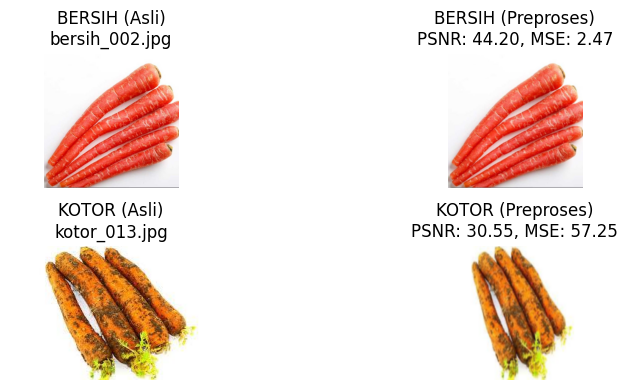

In [ ]:

# Folder augmentasi untuk demo
TEMP_AUG_DIR_BERSIH = os.path.join(DATA_DIR_AUG, 'bersih')
TEMP_AUG_DIR_KOTOR  = os.path.join(DATA_DIR_AUG, 'kotor')

# ==== Ambil file random ====
bersih_files = [f for f in os.listdir(os.path.join(DATA_DIR_RAW, 'bersih')) if f.lower().endswith(supported_ext)]
kotor_files  = [f for f in os.listdir(os.path.join(DATA_DIR_RAW, 'kotor')) if f.lower().endswith(supported_ext)]

selected_bersih = random.choice(bersih_files)
selected_kotor  = random.choice(kotor_files)

# ==== Load gambar raw ====
img_bersih = cv2.imread(os.path.join(DATA_DIR_RAW, 'bersih', selected_bersih))
img_kotor  = cv2.imread(os.path.join(DATA_DIR_RAW, 'kotor', selected_kotor))

# ==== Load gambar preprocessed dari folder aug ====
img_bersih_pre = cv2.imread(os.path.join(TEMP_AUG_DIR_BERSIH, f"{os.path.splitext(selected_bersih)[0]}_orig.png"))
img_kotor_pre  = cv2.imread(os.path.join(TEMP_AUG_DIR_KOTOR,  f"{os.path.splitext(selected_kotor)[0]}_orig.png"))

# ==== Resize raw ke ukuran preprocessed (256x256) ====
img_bersih_resized = cv2.resize(img_bersih, (256, 256), interpolation=cv2.INTER_AREA)
img_kotor_resized  = cv2.resize(img_kotor, (256, 256), interpolation=cv2.INTER_AREA)

# ==== Hitung PSNR & MSE ====
psnr_bersih = peak_signal_noise_ratio(img_bersih_resized, img_bersih_pre)
mse_bersih  = mean_squared_error(img_bersih_resized, img_bersih_pre)

psnr_kotor  = peak_signal_noise_ratio(img_kotor_resized, img_kotor_pre)
mse_kotor   = mean_squared_error(img_kotor_resized, img_kotor_pre)

# ==== Tampilkan ====
plt.figure(figsize=(10,4))

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img_bersih, cv2.COLOR_BGR2RGB))
plt.title(f"BERSIH (Asli)\n{selected_bersih}")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(img_bersih_pre, cv2.COLOR_BGR2RGB))
plt.title(f"BERSIH (Preproses)\nPSNR: {psnr_bersih:.2f}, MSE: {mse_bersih:.2f}")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(img_kotor, cv2.COLOR_BGR2RGB))
plt.title(f"KOTOR (Asli)\n{selected_kotor}")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(img_kotor_pre, cv2.COLOR_BGR2RGB))
plt.title(f"KOTOR (Preproses)\nPSNR: {psnr_kotor:.2f}, MSE: {mse_kotor:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()


##PSNR & MSE Citra Kelas Bersih (Asli VS Preproses)

In [ ]:
# ==========================================================
# HITUNG PSNR & MSE SEMUA CITRA DAN SIMPAN KE DATAFRAME
# ==========================================================

def compute_psnr_mse_df(raw_dir, aug_dir, kelas_label):
    data = []

    files = [f for f in os.listdir(raw_dir) if f.lower().endswith(supported_ext)]

    for filename in files:
        # Load raw
        img_raw = cv2.imread(os.path.join(raw_dir, filename))
        if img_raw is None:
            continue
        img_raw = cv2.resize(img_raw, (256, 256), interpolation=cv2.INTER_AREA)

        # Load preprocessed / augmentasi
        base = os.path.splitext(filename)[0]
        aug_file = os.path.join(aug_dir, f"{base}_orig.png")
        img_aug = cv2.imread(aug_file)
        if img_aug is None:
            continue

        # Hitung PSNR & MSE
        psnr = peak_signal_noise_ratio(img_raw, img_aug)
        mse  = mean_squared_error(img_raw, img_aug)

        data.append({
            "Nama File": filename,
            "Kelas": kelas_label,
            "PSNR": psnr,
            "MSE": mse
        })

    return pd.DataFrame(data)


# ==========================================================
# Hitung untuk semua kelas
# ==========================================================
df_bersih = compute_psnr_mse_df(os.path.join(DATA_DIR_RAW, 'bersih'), TEMP_AUG_DIR_BERSIH, "Bersih")
df_kotor  = compute_psnr_mse_df(os.path.join(DATA_DIR_RAW, 'kotor'),  TEMP_AUG_DIR_KOTOR,  "Kotor")

# Gabungkan menjadi satu DataFrame (corrected assignment)
df_psnr_mse_bersih = df_bersih
df_psnr_mse_kotor = df_kotor

df_psnr_mse_bersih = df_psnr_mse_bersih.sort_values(by='Nama File', inplace=False)
df_psnr_mse_bersih.head(25)

,Nama File,Kelas,PSNR,MSE
4,bersih_001.jpg,Bersih,52.358389,0.377782
2,bersih_002.jpg,Bersih,44.198255,2.473175
3,bersih_003.jpg,Bersih,45.673645,1.760824
13,bersih_004.jpg,Bersih,49.888536,0.667155
18,bersih_005.jpg,Bersih,52.576370,0.359289
14,bersih_006.jpg,Bersih,50.242624,0.614919
12,bersih_007.jpg,Bersih,51.704393,0.439178
15,bersih_008.jpg,Bersih,48.390241,0.942012
9,bersih_009.jpg,Bersih,53.707874,0.276881
16,bersih_010.jpg,Bersih,49.768821,0.685801


##PSNR & MSE Citra Kelas Kotor (Asli VS Preproses)

In [ ]:
df_psnr_mse_kotor = df_psnr_mse_kotor.sort_values(by='Nama File', inplace=False)
df_psnr_mse_kotor.head(25)

,Nama File,Kelas,PSNR,MSE
16,kotor_001.jpg,Kotor,32.879121,33.509521
3,kotor_002.jpg,Kotor,30.136647,63.010895
21,kotor_003.jpg,Kotor,32.001202,41.016647
23,kotor_004.jpg,Kotor,35.231987,19.493134
0,kotor_005.jpg,Kotor,34.269173,24.331172
15,kotor_006.jpg,Kotor,30.136647,63.010895
1,kotor_007.jpg,Kotor,36.551404,14.385997
18,kotor_008.jpg,Kotor,34.600708,22.542887
11,kotor_009.jpg,Kotor,33.527438,28.862676
14,kotor_010.jpg,Kotor,28.508855,91.663172


## Segmentasi (Grab-cut)

In [ ]:
def grabcut_segment(img):
    mask = np.zeros(img.shape[:2], np.uint8)

    # model background & foreground (dibutuhkan GrabCut)
    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)

    # Tentukan ROI (bisa otomatis pakai bounding box seluruh gambar)
    height, width = img.shape[:2]
    rect = (10, 10, width-20, height-20)

    # GrabCut
    cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)

    # Buat mask final: foreground (1/3) → 1, background (0/2) → 0
    final_mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

    segmented = img * final_mask[:, :, np.newaxis]
    return segmented, final_mask


##Tes Hasil Grabcut

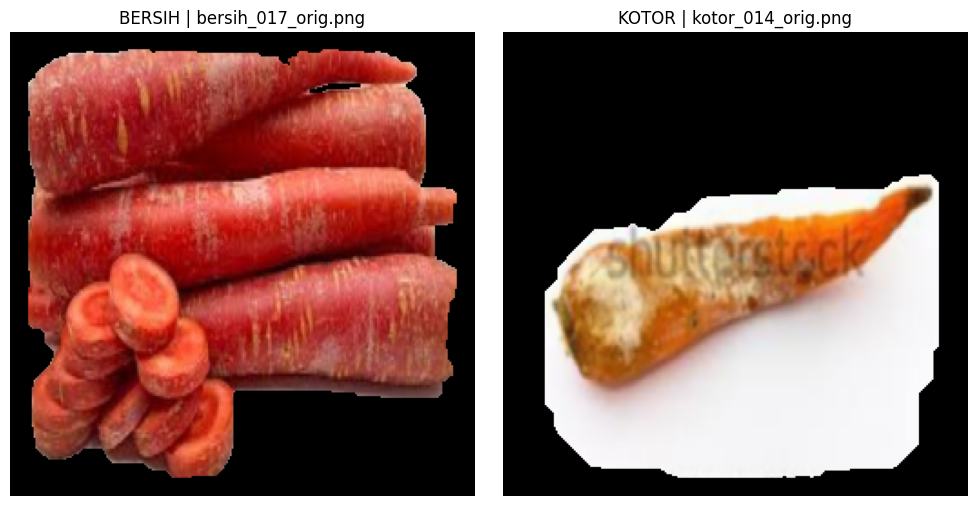

In [ ]:
def show_random_grabcut_aug():
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    idx = 0

    for cname in ['bersih', 'kotor']:
        folder = os.path.join(DATA_DIR_AUG, cname)

        if not os.path.isdir(folder):
            print("Folder tidak ditemukan:", folder)
            continue

        # list file gambar
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        if len(files) == 0:
            print("Tidak ada gambar di:", folder)
            continue

        # ambil satu random
        fname = random.choice(files)
        path = os.path.join(folder, fname)

        # read image augmented
        img = cv2.imread(path)
        if img is None:
            print("Gagal load:", fname)
            continue

        # GRABCUT
        seg, mask = grabcut_segment(img)

        # convert BGR to RGB
        seg_rgb = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

        ax[idx].imshow(seg_rgb)
        ax[idx].set_title(f"{cname.upper()} | {fname}")
        ax[idx].axis('off')
        idx += 1

    plt.tight_layout()
    plt.show()


show_random_grabcut_aug()


## Ekstraksi Fitur Warna

In [ ]:
def extract_color_features(img, color_mode: str = "strict"):
    if color_mode == "strict":
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    H, S, V = cv2.split(hsv)

    features = {
        "H_mean": np.mean(H), "H_std": np.std(H),
        "S_mean": np.mean(S), "S_std": np.std(S),
        "V_mean": np.mean(V), "V_std": np.std(V)
    }
    return features


## Ekstraksi Fitur GLCM

In [ ]:
def extract_glcm(img_gray):
    # Hitung GLCM dengan 4 arah
    glcm = graycomatrix(
        img_gray,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=256,
        symmetric=True,
        normed=True
    )

    # --- Fitur dasar GLCM ---
    contrast = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    ASM = graycoprops(glcm, 'ASM').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    # --- Rata-rata GLCM untuk semua arah ---
    P = glcm.mean(axis=(2,3))  # shape (256,256)

    I, J = np.indices(P.shape)

    # Total variance
    mean_glcm = (P * I).sum()
    total_var = ((I - mean_glcm)**2 * P).sum()

    # Difference probability
    diff_prob = np.zeros(256)
    for k in range(256):
        diff_prob[k] = np.sum(P[k, :]) + np.sum(P[:, k])

    difference_variance = np.var(diff_prob)
    difference_entropy = -np.sum(diff_prob * np.log2(diff_prob + 1e-12))

    # Maximum probability
    max_prob = P.max()

    # Joint entropy
    joint_entropy = -np.sum(P * np.log2(P + 1e-12))

    features = {
        "energy": energy,
        "contrast": contrast,
        "correlation": correlation,
        "homogeneity": homogeneity,
        "total_variance": total_var,
        "difference_variance": difference_variance,
        "maximum_probability": max_prob,
        "joint_entropy": joint_entropy,
        "difference_entropy": difference_entropy,
        "ASM": ASM
    }

    return features


## Load Segmentasi dan Ekstraksi Fitur

In [ ]:
classes = {'bersih': 0, 'kotor': 1}
X = []   # fitur
y = []   # label

t0 = time.time()

for cname, label in classes.items():

    folder = os.path.join(DATA_DIR_AUG, cname)
    if not os.path.isdir(folder):
        print('Missing folder:', folder)
        continue

    # hanya baca file hasil preprocessing/augmentasi
    files = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
    print(f'{cname}: {len(files)} file')

    for i, f in enumerate(files, start=1):

        path = os.path.join(folder, f)
        img = cv2.imread(path)

        if img is None:
            print("!! gagal load:", f)
            continue

        # =====================
        # 1. SEGMENTASI GRABCUT
        # =====================
        seg, mask = grabcut_segment(img)

        # =====================
        # 2. FITUR WARNA (HSV)
        # =====================
        feat_color = extract_color_features(seg)

        # =====================
        # 3. FITUR GLCM
        # =====================
        gray = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
        feat_glcm = extract_glcm(gray)

        # Gabungkan fitur warna + tekstur
        feats = list(feat_color.values()) + list(feat_glcm.values())

        X.append(feats)
        y.append(label)

        if i % 20 == 0:
            print(f'  progress {cname}: {i}/{len(files)}')

# =====================
# KONVERSI KE ARRAY
# =====================
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print('\n====================')
print('Total sampel:', len(X))
print('Waktu eksekusi:', round(time.time() - t0, 2), 'detik')
print('Bersih:', (y == 0).sum(), '| Kotor:', (y == 1).sum())
print('Shape fitur:', X.shape)

assert len(set(y)) == 2, 'Dataset harus terdiri dari 2 kelas'


bersih: 200 file
  progress bersih: 20/200
  progress bersih: 40/200
  progress bersih: 60/200
  progress bersih: 80/200
  progress bersih: 100/200
  progress bersih: 120/200
  progress bersih: 140/200
  progress bersih: 160/200
  progress bersih: 180/200
  progress bersih: 200/200
kotor: 200 file
  progress kotor: 20/200
  progress kotor: 40/200
  progress kotor: 60/200
  progress kotor: 80/200
  progress kotor: 100/200
  progress kotor: 120/200
  progress kotor: 140/200
  progress kotor: 160/200
  progress kotor: 180/200
  progress kotor: 200/200

Total sampel: 400
Waktu eksekusi: 299.74 detik
Bersih: 200 | Kotor: 200
Shape fitur: (400, 16)


##Histogram Fitur Seluruh Sampel Citra (Ekstraksi Fitur Warna + GLCM)

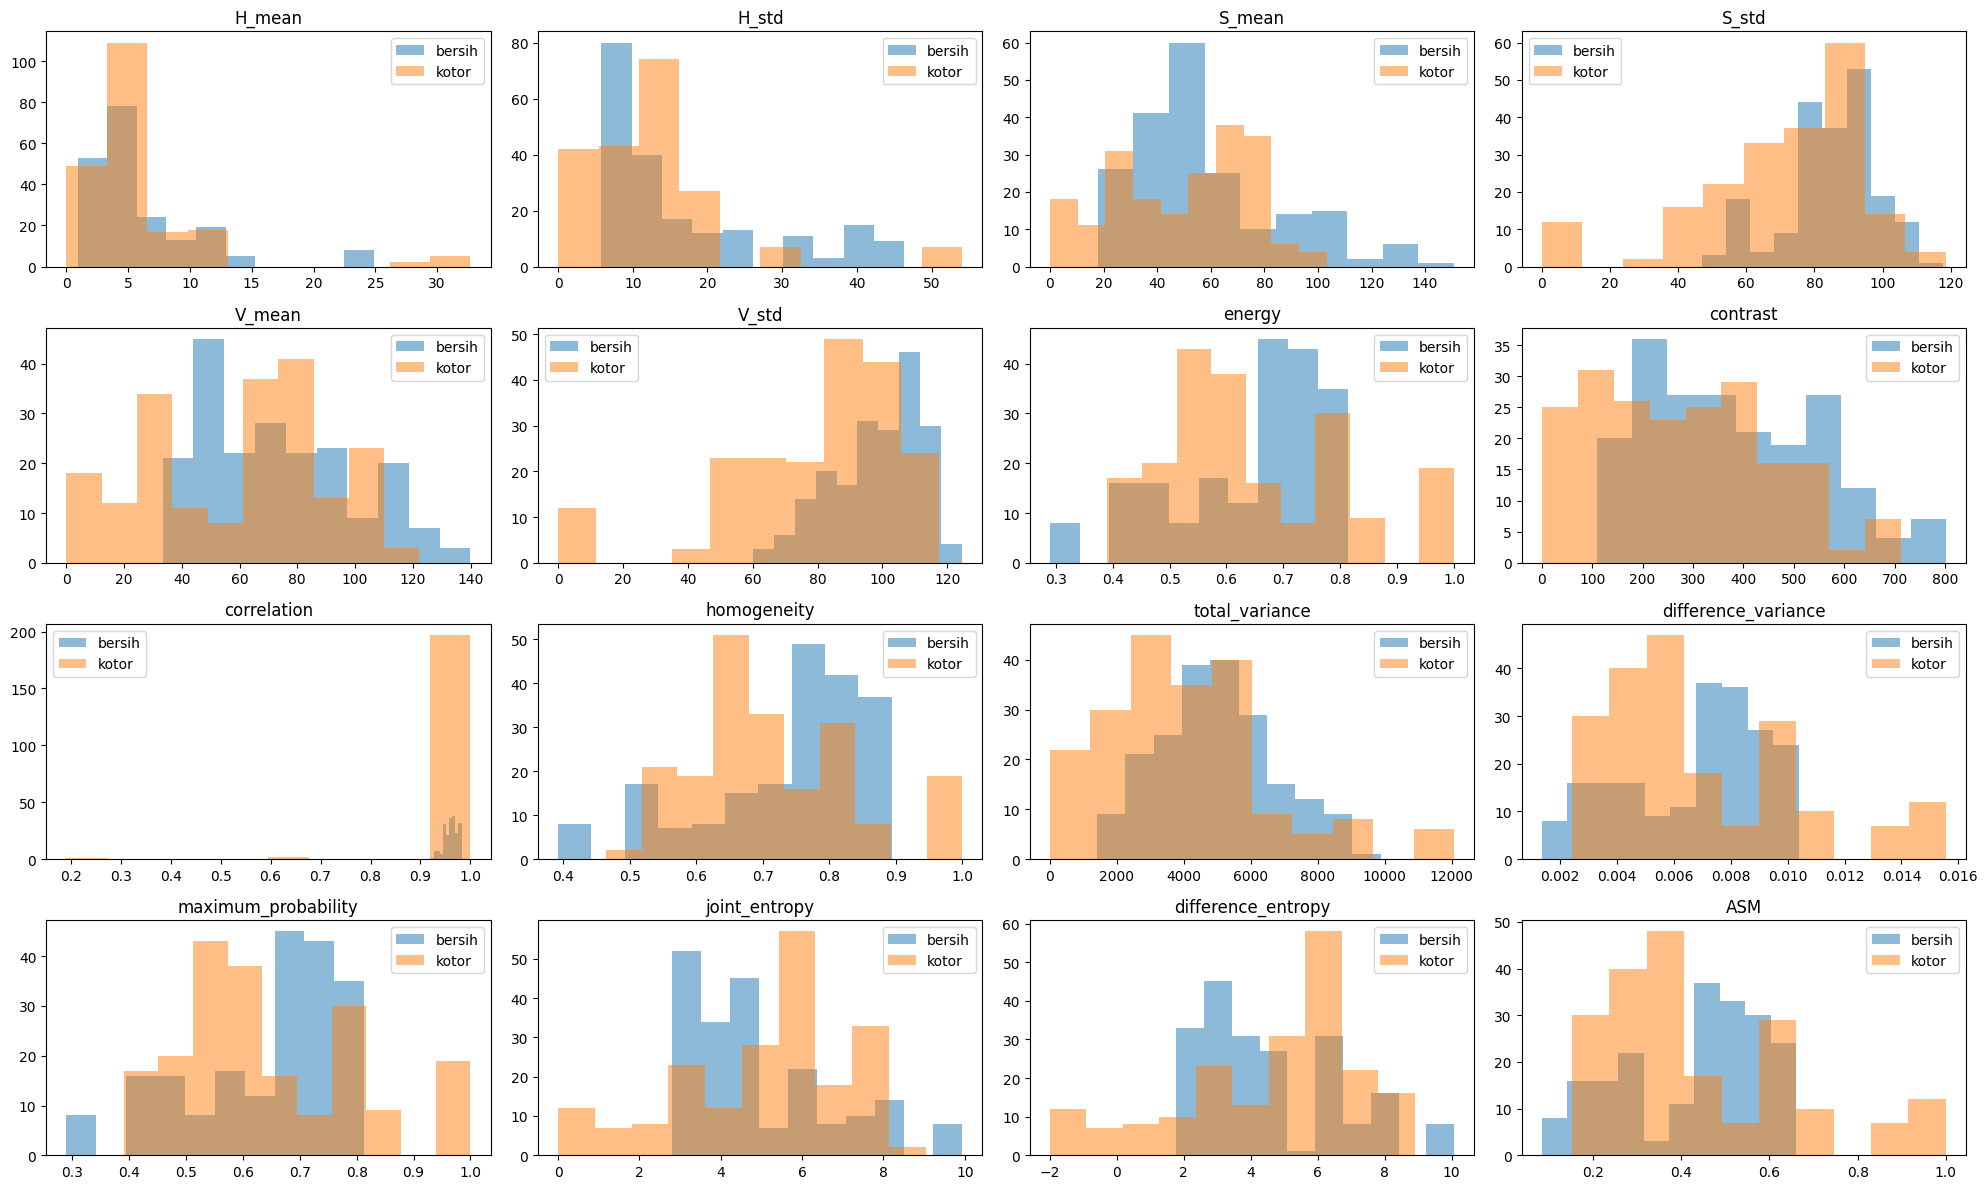

In [ ]:
feature_names = list(feat_color.keys()) + list(feat_glcm.keys())
X_arr = np.array(X)

n_features = len(feature_names)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(20, n_rows*3))
for i, fname in enumerate(feature_names):
    plt.subplot(n_rows, n_cols, i+1)
    plt.hist(X_arr[y==0, i], alpha=0.5, label='bersih')
    plt.hist(X_arr[y==1, i], alpha=0.5, label='kotor')
    plt.title(fname)
    plt.legend()
plt.tight_layout()
plt.show()


## Klasifikasi (SVM) -> Tabel Akurasi + Confusion Matrix

Akurasi: 0.9875
              precision    recall  f1-score   support

      bersih       0.98      1.00      0.99        40
       kotor       1.00      0.97      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



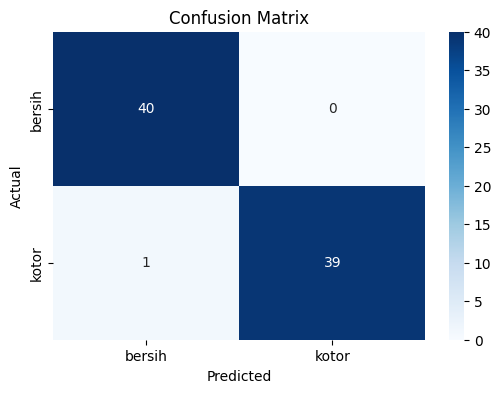

In [ ]:

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- SVM Pipeline ---
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True))
])

clf.fit(X_train, y_train)

# --- Prediksi ---
pred = clf.predict(X_test)

# --- Evaluasi ---
print("Akurasi:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=['bersih','kotor']))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['bersih', 'kotor'],
            yticklabels=['bersih', 'kotor'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



##Histogram Probabilitas (SVM)

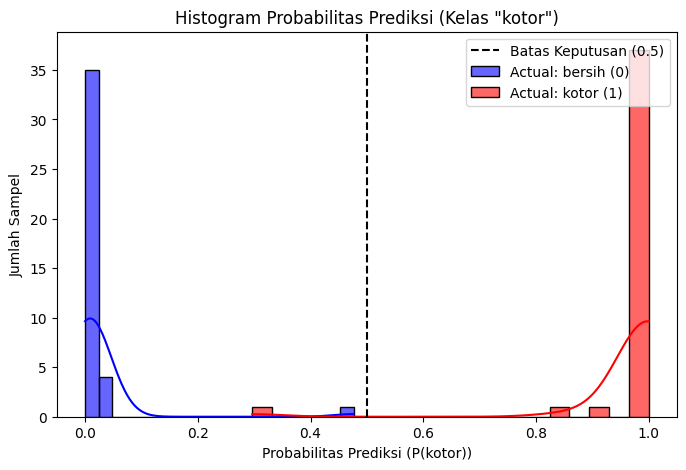

In [ ]:

# ===================================================
#                HISTOGRAM PROBABILITAS
# ===================================================

# Probabilitas prediksi kelas "kotor" (asumsi label kotor = 1)
y_proba = clf.predict_proba(X_test)
proba_kotor = y_proba[:, 1]   # probabilitas kelas 1

# Pisahkan berdasarkan kelas aktual
proba_bersih_actual = proba_kotor[y_test == 0]
proba_kotor_actual = proba_kotor[y_test == 1]

plt.figure(figsize=(8, 5))
sns.histplot(proba_bersih_actual, bins=20, kde=True, color='blue',
             label='Actual: bersih (0)', alpha=0.6)
sns.histplot(proba_kotor_actual, bins=20, kde=True, color='red',
             label='Actual: kotor (1)', alpha=0.6)

plt.title('Histogram Probabilitas Prediksi (Kelas "kotor")')
plt.xlabel('Probabilitas Prediksi (P(kotor))')
plt.ylabel('Jumlah Sampel')
plt.axvline(0.5, color='black', linestyle='--', label='Batas Keputusan (0.5)')
plt.legend()
plt.show()


## Klasifikasi (KNN) -> Tabel Akurasi + Confusion Matrix

Akurasi KNN: 0.975

=== Classification Report (KNN) ===
              precision    recall  f1-score   support

      bersih       0.95      1.00      0.98        40
       kotor       1.00      0.95      0.97        40

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



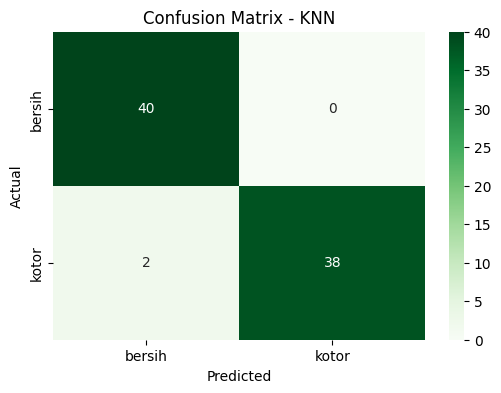

In [ ]:
# ===================================================
#               KNN CLASSIFIER PIPELINE
# ===================================================

# --- KNN Pipeline ---
knn_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

# Train
knn_clf.fit(X_train, y_train)

# Predict
knn_pred = knn_clf.predict(X_test)

# Evaluation
print("Akurasi KNN:", accuracy_score(y_test, knn_pred))
print("\n=== Classification Report (KNN) ===")
print(classification_report(y_test, knn_pred, target_names=['bersih','kotor']))

# --- Confusion Matrix KNN ---
knn_cm = confusion_matrix(y_test, knn_pred)

plt.figure(figsize=(6,4))
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=['bersih', 'kotor'],
            yticklabels=['bersih', 'kotor'])
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


##Histogram Probabilitas (KNN)

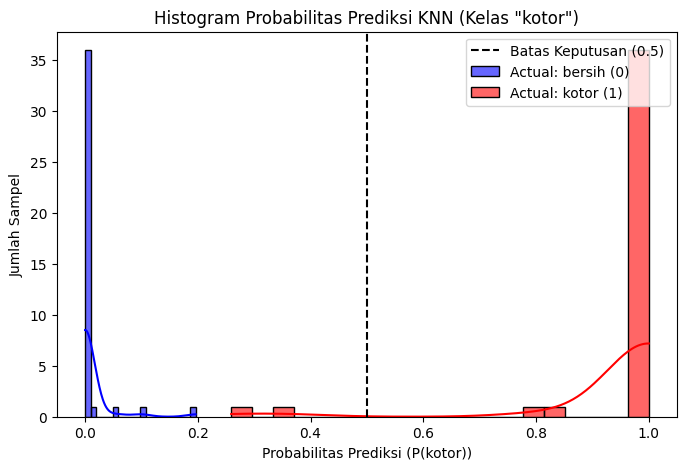

In [ ]:
# ===================================================
#       HISTOGRAM PROBABILITAS KNN (kelas kotor)
# ===================================================

# probability output for class 1 (kotor)
knn_proba = knn_clf.predict_proba(X_test)
knn_proba_kotor = knn_proba[:, 1]

# pisahkan berdasarkan kelas aktual
knn_proba_bersih_actual = knn_proba_kotor[y_test == 0]
knn_proba_kotor_actual  = knn_proba_kotor[y_test == 1]

plt.figure(figsize=(8,5))
sns.histplot(knn_proba_bersih_actual, bins=20, kde=True, color='blue',
             label='Actual: bersih (0)', alpha=0.6)
sns.histplot(knn_proba_kotor_actual, bins=20, kde=True, color='red',
             label='Actual: kotor (1)', alpha=0.6)

plt.title('Histogram Probabilitas Prediksi KNN (Kelas "kotor")')
plt.xlabel('Probabilitas Prediksi (P(kotor))')
plt.ylabel('Jumlah Sampel')
plt.axvline(0.5, color='black', linestyle='--', label='Batas Keputusan (0.5)')
plt.legend()
plt.show()


## PERBANDINGAN SVM & KNN PADA BERBAGAI TRAIN-TEST SPLIT

In [ ]:

# ===================================================
# PERBANDINGAN SVM & KNN PADA BERBAGAI TRAIN-TEST SPLIT
# ===================================================

splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # train sizes
results = []

for train_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size,
        random_state=42, stratify=y
    )

    # -----------------------
    # SVM
    # -----------------------
    svm_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
    ])
    svm_clf.fit(X_train, y_train)
    svm_pred = svm_clf.predict(X_test)

    svm_acc  = accuracy_score(y_test, svm_pred)
    svm_prec, svm_rec, svm_f1, _ = precision_recall_fscore_support(
        y_test, svm_pred, average='macro'
    )

    # -----------------------
    # KNN
    # -----------------------
    knn_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))
    ])
    knn_clf.fit(X_train, y_train)
    knn_pred = knn_clf.predict(X_test)

    knn_acc  = accuracy_score(y_test, knn_pred)
    knn_prec, knn_rec, knn_f1, _ = precision_recall_fscore_support(
        y_test, knn_pred, average='macro'
    )

    # -----------------------
    # Simpan hasil ke tabel
    # -----------------------
    display_test_size = 1 - train_size
    results.append({
        "Train Size": f"{int(train_size*100)}:{int(display_test_size*100)}",

        # ---- SVM ----
        # ---- KNN ----
        "Akurasi SVM": round(svm_acc, 4),
        "Akurasi KNN": round(knn_acc, 4),
        "Precision SVM": round(svm_prec, 4),
        "Precision KNN": round(knn_prec, 4),
        "Recall SVM": round(svm_rec, 4),
        "Recall KNN": round(knn_rec, 4),
        "F1-score SVM": round(svm_f1, 4),
        "F1-score KNN": round(knn_f1, 4),

    })

# Convert dataframe
df_results = pd.DataFrame(results)

print("\n=== PERBANDINGAN AKURASI, PRECISION, RECALL, F1 SVM vs KNN ===\n")
display(df_results)

# ===================================================
# MENAMPILKAN PERFORMA TERBAIK SETIAP METODE
# ===================================================

# SVM terbaik berdasarkan F1-score
best_svm = df_results.loc[df_results["F1-score SVM"].idxmax()]

# KNN terbaik berdasarkan F1-score
best_knn = df_results.loc[df_results["F1-score KNN"].idxmax()]

print("\n=== HASIL TERBAIK BERDASARKAN F1-SCORE ===")

print("\n🔵 SVM Terbaik:")
display(best_svm.to_frame().T)

print("\n🟢 KNN Terbaik:")
display(best_knn.to_frame().T)



=== PERBANDINGAN AKURASI, PRECISION, RECALL, F1 SVM vs KNN ===



,Train Size,Akurasi SVM,Akurasi KNN,Precision SVM,Precision KNN,Recall SVM,Recall KNN,F1-score SVM,F1-score KNN
0,10:90,0.8639,0.8361,0.8859,0.8438,0.8639,0.8361,0.8619,0.8352
1,20:80,0.9594,0.9344,0.9608,0.9344,0.9594,0.9344,0.9593,0.9344
2,30:70,0.9607,0.9179,0.9626,0.9179,0.9607,0.9179,0.9607,0.9179
3,40:60,0.9625,0.9458,0.9641,0.9466,0.9625,0.9458,0.9625,0.9458
4,50:50,0.9750,0.9550,0.9762,0.9561,0.9750,0.9550,0.9750,0.9550
5,60:40,0.9938,0.9812,0.9938,0.9813,0.9938,0.9812,0.9937,0.9812
6,70:30,0.9917,0.9833,0.9918,0.9839,0.9917,0.9833,0.9917,0.9833
7,80:19,0.9875,0.9750,0.9878,0.9762,0.9875,0.9750,0.9875,0.9750
8,90:9,0.9750,0.9750,0.9762,0.9762,0.9750,0.9750,0.9750,0.9750



=== HASIL TERBAIK BERDASARKAN F1-SCORE ===

🔵 SVM Terbaik:


,Train Size,Akurasi SVM,Akurasi KNN,Precision SVM,Precision KNN,Recall SVM,Recall KNN,F1-score SVM,F1-score KNN
5,60:40,0.9938,0.9812,0.9938,0.9813,0.9938,0.9812,0.9937,0.9812



🟢 KNN Terbaik:


,Train Size,Akurasi SVM,Akurasi KNN,Precision SVM,Precision KNN,Recall SVM,Recall KNN,F1-score SVM,F1-score KNN
6,70:30,0.9917,0.9833,0.9918,0.9839,0.9917,0.9833,0.9917,0.9833


## Simpan Model

In [ ]:
joblib.dump(clf, MODEL_PATH)
print('Saved:', MODEL_PATH)

Saved: /content/drive/MyDrive/vegetable-cleanliness-api/models/svm_model.pkl


## Demo Prediksi Satu Gambar

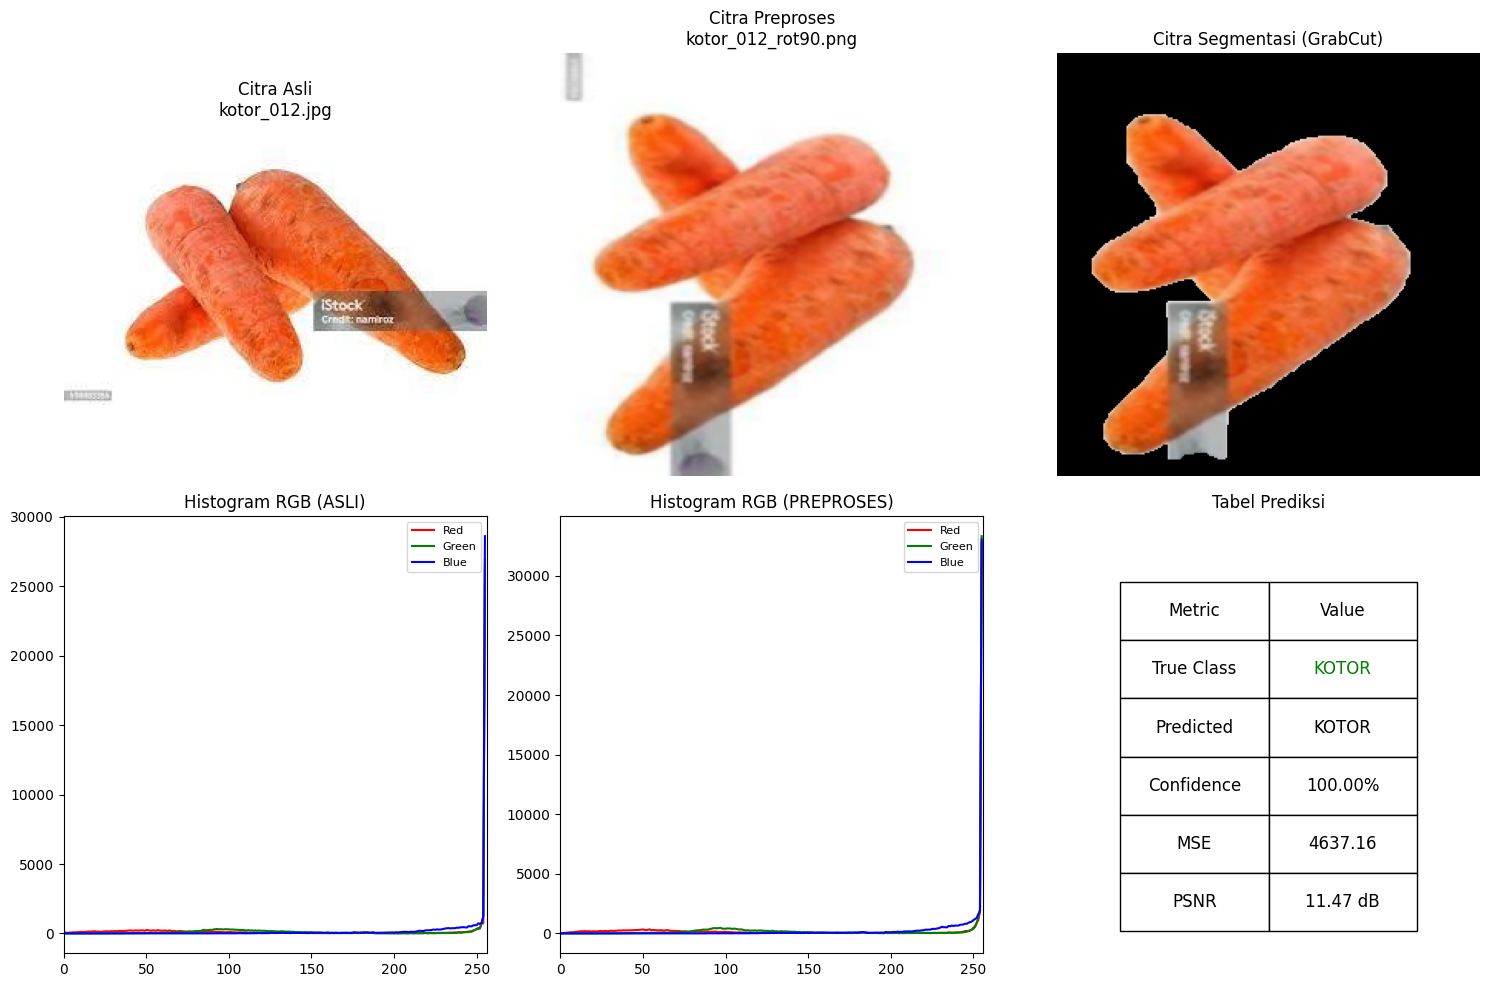

In [ ]:
# === LOAD MODEL ===
model_path = "/content/drive/MyDrive/vegetable-cleanliness-api/models/svm_model.pkl"
with open(model_path, 'rb') as f:
    clf = joblib.load(f)

# === Ambil index random dari X_test ===
random_idx = random.randint(0, len(X_test) - 1)
test_features = X_test[random_idx].reshape(1, -1)
true_label = y_test[random_idx]
true_class = 'bersih' if true_label == 0 else 'kotor'

# === Ambil gambar sesuai kelas untuk visualisasi ===
folder_raw = os.path.join(DATA_DIR_RAW, true_class)
folder_aug = os.path.join(DATA_DIR_AUG, true_class)

# Filter file
files_raw = [f for f in os.listdir(folder_raw) if f.lower().endswith(('.jpg','.png','.jpeg'))]
files_aug = [f for f in os.listdir(folder_aug) if f.lower().endswith(('.jpg','.png','.jpeg'))]

# Pilih random raw
test_fname_raw = random.choice(files_raw)
test_img_raw = cv2.imread(os.path.join(folder_raw, test_fname_raw))

# Cari aug yang berasal dari raw yang sama
raw_base = os.path.splitext(test_fname_raw)[0]
matching_aug = [f for f in files_aug if f.startswith(raw_base)]
if matching_aug:
    test_fname_aug = random.choice(matching_aug)
else:
    # fallback: gunakan raw kalau augmentasi tidak ada
    test_fname_aug = test_fname_raw
test_img_aug = cv2.imread(os.path.join(folder_aug, test_fname_aug))

# === PREDIKSI ===
pred_label = clf.predict(test_features)[0]
pred_proba = clf.predict_proba(test_features)[0]
pred_class = 'bersih' if pred_label == 0 else 'kotor'
confidence = pred_proba[pred_label] * 100

# === SEGMENTASI ===
seg, mask = grabcut_segment(test_img_aug)

# ============================================================
# Fungsi histogram RGB
# ============================================================
def show_histogram(ax, img_rgb, title="Histogram RGB"):
    colors = ['r', 'g', 'b']
    labels = ['Red', 'Green', 'Blue']

    for i in range(3):
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
        ax.plot(hist, color=colors[i], label=labels[i])
        ax.set_xlim([0, 256])

    ax.set_title(title)
    ax.legend(fontsize=8)
    ax.grid(False)


# ============================================================
# Fungsi PSNR & MSE
# ============================================================
def compare_PSNR_MSE(img1, img2):
    if img1.shape != img2.shape:
        img1_resized = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
    else:
        img1_resized = img1.copy()

    mse = mean_squared_error(img1_resized, img2)
    psnr = peak_signal_noise_ratio(img1_resized, img2)
    return mse, psnr


# === Hitung MSE & PSNR antara raw dan augmented ===
mse, psnr = compare_PSNR_MSE(test_img_raw, test_img_aug)

# === Tentukan status prediksi ===
status_text = "✓ BENAR" if pred_class == true_class else "✗ SALAH"

# ============================================================
# VISUALISASI FINAL: Histogram + Prediction di subplot yang sama
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# -----------------------------
# Baris 1: Citra
# -----------------------------
axes[0,0].imshow(cv2.cvtColor(test_img_raw, cv2.COLOR_BGR2RGB))
axes[0,0].set_title(f'Citra Asli\n{test_fname_raw}')
axes[0,0].axis('off')

axes[0,1].imshow(cv2.cvtColor(test_img_aug, cv2.COLOR_BGR2RGB))
axes[0,1].set_title(f'Citra Preproses\n{test_fname_aug}')
axes[0,1].axis('off')

axes[0,2].imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))
axes[0,2].set_title('Citra Segmentasi (GrabCut)')
axes[0,2].axis('off')

# -----------------------------
# Baris 2: Histogram dan Prediction + Tabel
# -----------------------------
# Histogram Raw
show_histogram(axes[1,0], test_img_raw, title="Histogram RGB (ASLI)")

# Histogram Augmented
show_histogram(axes[1,1], test_img_aug, title="Histogram RGB (PREPROSES)")

# Prediction + Tabel di subplot axes[1,2]
axes[1,2].set_title('Tabel Prediksi')
axes[1,2].axis('off')

# Warna prediksi pada tabel
result_color = 'green' if pred_class == true_class else 'red'

# ==============================
# DATA TABEL
# ==============================
table_data = [
    ["True Class",  true_class.upper()],
    ["Predicted",   pred_class.upper()],
    ["Confidence",  f"{confidence:.2f}%"],
    ["MSE",         f"{mse:.2f}"],
    ["PSNR",        f"{psnr:.2f} dB"]]

table = axes[1,2].table(
    cellText=table_data,
    colLabels=["Metric", "Value"],
    cellLoc='center',
    bbox=[0.15, 0.05, 0.7, 0.8]   # [x, y, width, height]
)

# Styling tabel
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Warnai baris Predicted sesuai benar/salah
pred_row = 1  # index ke-1
table[(pred_row, 1)].get_text().set_color(result_color)


plt.tight_layout()
plt.show()
